In [1]:
%env PYTHONHASHSEED=0
seed_value=101
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
from tensorflow import set_random_seed
set_random_seed(seed_value)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import PowerTransformer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import SCORERS
from numpy import mean, std
from numpy import math
import pickle
from sklearn.model_selection import GridSearchCV
from math import sin, cos, sqrt, atan2, radians
from tensorflow.keras import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense

%matplotlib inline

env: PYTHONHASHSEED=0


C:\Users\mahta\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mahta\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mahta\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mahta\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:

wellheader=pd.read_csv('WellHeader_Datathon.csv')


C:\Users\mahta\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (24,26,27,28,52,54,55,56,80,81) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## parameter selection for TVD


In [3]:
wellheader.drop(['Match', '_Perf`Flag','_Completed`Flag','CompletionDate'], axis=1,inplace=True)
wellheader.drop(['LicenceDate', 'ConfidentialReleaseDate','AbandonDate',
                 'SurfAbandonDate','OSDeposit','Country','StatusDate','Agent'], axis=1,inplace=True)

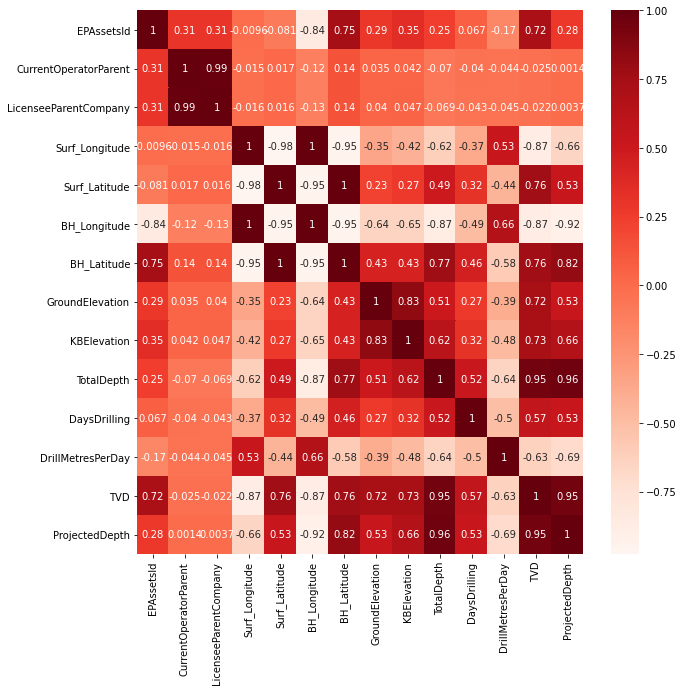

In [4]:
cor = wellheader.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [5]:
#function to use later to define a new feature
from math import sin, cos, sqrt, atan2, radians
def distance(lt1,lo1,lt2,lo2):
    # approximate radius of earth in km
    R = 6373.0
    lat1 = radians(lt1)
    lon1 = radians(lo1)
    lat2 = radians(lt2)
    lon2 = radians(lo2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return(distance)

In [6]:
#removing samples without TVD
wellheader1=wellheader.copy()
wellheader1=wellheader1[wellheader1['TVD'].notna()]

In [7]:
#defining distance and approximate
wellheader1.reset_index(inplace=True,drop=True)
wellheader1['distance']=np.nan
a=list()
for i in range(0,len(wellheader1)):
    lat1=wellheader1['Surf_Latitude'].values[i]
    lon1=wellheader1['Surf_Longitude'].values[i]
    lat2=wellheader1['BH_Latitude'].values[i]
    lon2=wellheader1['BH_Longitude'].values[i]
    wellheader1['distance'][i]=distance(lat1,lon1,lat2,lon2)
wellheader1['distance']=wellheader1['distance']*1000
wellheader1['approx']=wellheader1['TotalDepth']-wellheader1['distance']

C:\Users\mahta\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [8]:
y=wellheader1['TVD']-wellheader1['approx']
x=wellheader1[['EPAssetsId','Surf_Longitude','Surf_Latitude','GroundElevation','KBElevation','TotalDepth','DaysDrilling','DrillMetresPerDay','BH_Latitude','BH_Longitude','distance','approx']]


In [9]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
fs=SelectKBest(score_func=f_regression,k=5)
fs.fit(x,y)

SelectKBest(k=5, score_func=<function f_regression at 0x0000011B4B51D4C8>)

Feature EPAssetsId: 187.466473
Feature Surf_Longitude: 197.003167
Feature Surf_Latitude: 166.747488
Feature GroundElevation: 94.911481
Feature KBElevation: 96.619090
Feature TotalDepth: 268.239790
Feature DaysDrilling: 140.140887
Feature DrillMetresPerDay: 153.830821
Feature BH_Latitude: 167.633982
Feature BH_Longitude: 196.857639
Feature distance: 28.780376
Feature approx: 610.576047


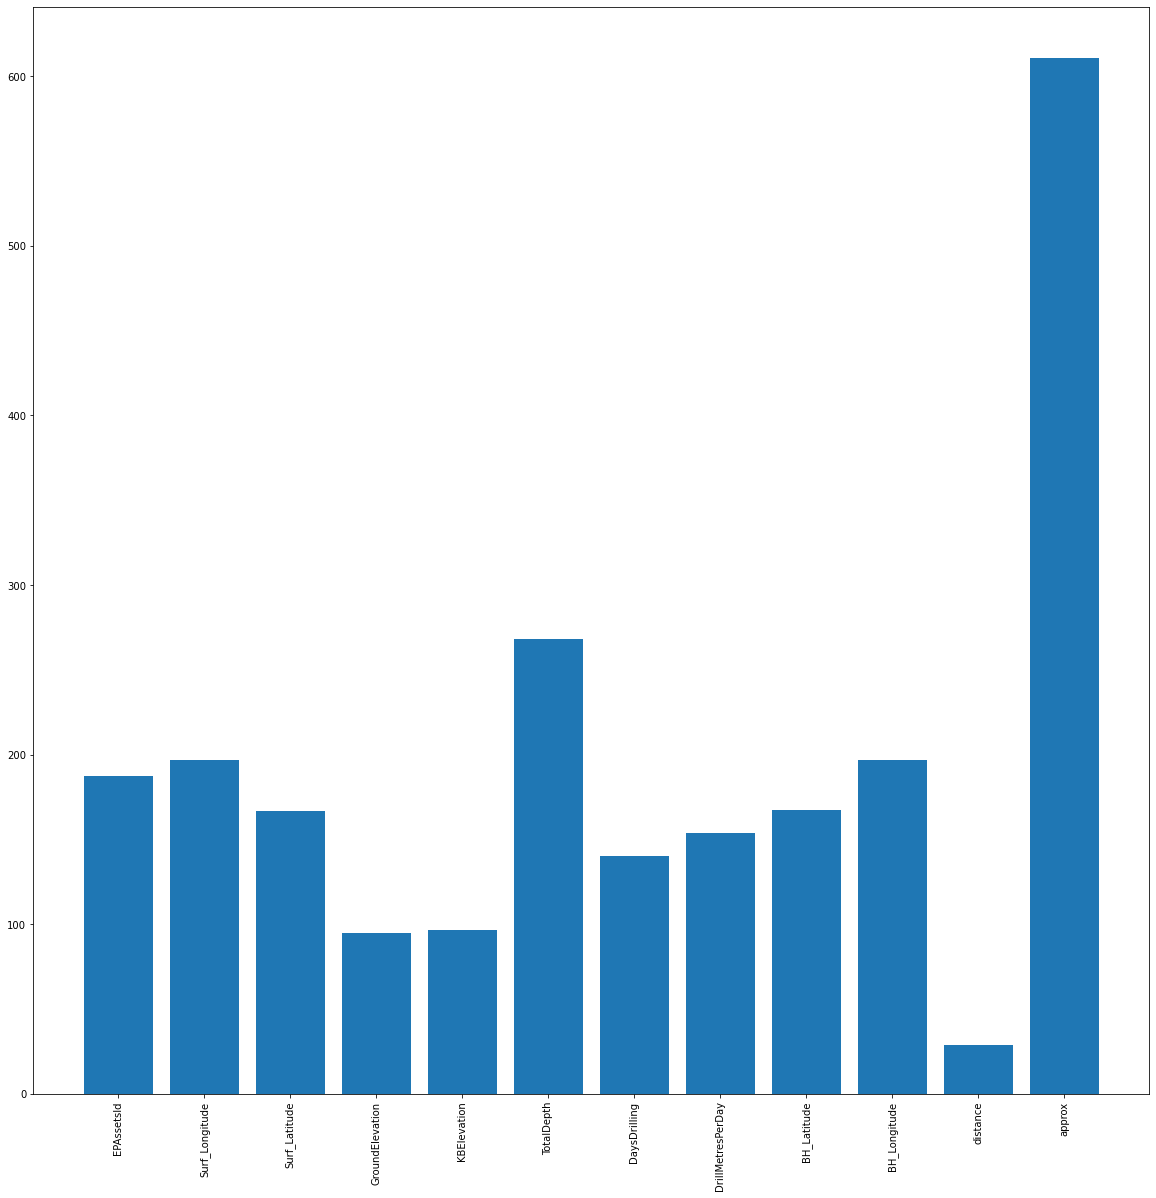

In [19]:
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (x.columns[i], fs.scores_[i]))
# plot the scores
plt.figure(figsize=(20,20))
plt.bar([x.columns[i] for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(rotation=90)
plt.show()

In [20]:
#can we make new features by combining previous ones?
import featuretools as ft
es = ft.EntitySet(id = 'wells')
es = es.entity_from_dataframe(entity_id = 'wells', dataframe = x, 
                              index = 'EPAssetsId')
features, feature_names = ft.dfs(entityset = es, target_entity = 'wells', 
                                trans_primitives = ['add_numeric', 'multiply_numeric','subtract_numeric','divide_numeric','diff'],max_depth=2)
features.dropna(axis='columns',inplace=True)
features

C:\Users\mahta\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,Surf_Longitude,Surf_Latitude,GroundElevation,KBElevation,TotalDepth,DaysDrilling,DrillMetresPerDay,BH_Latitude,BH_Longitude,distance,...,distance - TotalDepth / distance + GroundElevation,distance - TotalDepth / distance + KBElevation,distance - TotalDepth / distance + Surf_Latitude,distance - TotalDepth / distance + Surf_Longitude,distance - TotalDepth / distance + TotalDepth,distance - TotalDepth / distance - DrillMetresPerDay,distance - TotalDepth / distance - GroundElevation,distance - TotalDepth / distance - KBElevation,distance - TotalDepth / distance - Surf_Latitude,distance - TotalDepth / distance - Surf_Longitude
EPAssetsId,,,,,,,,,,,,,,,,,,,,,
2593278,-117.527042,54.737446,766.3,770.8,3607.0,13.0,277.46,54.739474,-117.553836,1735.275458,...,-0.748218,-0.746875,-1.045649,-1.156994,-0.350361,-1.283924,-1.931653,-1.940666,-1.113765,-1.010213
2579437,-117.559923,54.730864,754.5,759.4,3502.0,13.0,269.38,54.733247,-117.534302,1666.700148,...,-0.758012,-0.756481,-1.066148,-1.184722,-0.355080,-1.313443,-2.011949,-2.022814,-1.138545,-1.028606
2591761,-117.560141,54.730703,755.3,759.8,3491.0,12.0,290.92,54.729643,-117.534282,1665.030684,...,-0.754430,-0.753030,-1.061757,-1.179970,-0.354142,-1.328837,-2.007154,-2.017131,-1.133931,-1.024335
2587302,-117.561283,54.723339,764.0,767.7,3578.0,11.0,325.27,54.725986,-117.534295,1758.423261,...,-0.721361,-0.720304,-1.003546,-1.108915,-0.340973,-1.269632,-1.829781,-1.836615,-1.068015,-0.969932
2600942,-117.639433,54.787071,718.5,725.0,3659.0,7.0,522.71,54.773161,-117.656352,1889.912503,...,-0.678224,-0.676538,-0.909697,-0.998203,-0.318817,-1.293947,-1.510217,-1.518644,-0.964014,-0.881216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619591,-111.199446,51.895504,773.1,777.7,2068.0,18.0,114.89,51.902829,-111.210328,1105.285100,...,-0.512523,-0.511271,-0.831949,-0.968443,-0.303381,-0.972051,-2.898128,-2.938824,-0.913921,-0.791391
2619592,-111.199446,51.895432,773.0,777.7,2076.0,16.0,129.75,51.889342,-111.188136,1030.342072,...,-0.579844,-0.578337,-0.966200,-1.137645,-0.336620,-1.161078,-4.063300,-4.138891,-1.068692,-0.916005
2614697,-114.367997,51.272852,1234.0,1239.9,5531.0,10.0,553.10,51.242427,-114.370708,3389.425192,...,-0.463201,-0.462611,-0.622425,-0.653905,-0.240075,-0.755053,-0.993574,-0.996301,-0.641545,-0.611216


In [21]:
features.replace([np.inf, -np.inf], np.nan,inplace=True)
features.dropna(axis='columns',inplace=True)

In [22]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
fs=SelectKBest(score_func=f_regression,k=5)
fs.fit(features,y)

C:\Users\mahta\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\mahta\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\mahta\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\mahta\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=5, score_func=<function f_regression at 0x0000018B5D2AB9D8>)

Feature Surf_Longitude: 197.003167
Feature Surf_Latitude: 166.747488
Feature GroundElevation: 94.911481
Feature KBElevation: 96.619090
Feature TotalDepth: 268.239790
Feature DaysDrilling: 140.140887
Feature DrillMetresPerDay: 153.830821
Feature BH_Latitude: 167.633982
Feature BH_Longitude: 196.857639
Feature distance: 28.780376
Feature approx: 610.576047
Feature BH_Latitude + BH_Longitude: 195.291934
Feature BH_Latitude + DaysDrilling: 148.542743
Feature BH_Latitude + DrillMetresPerDay: 153.434059
Feature BH_Latitude + GroundElevation: 96.702717
Feature BH_Latitude + KBElevation: 98.401205
Feature BH_Latitude + Surf_Latitude: 167.193965
Feature BH_Latitude + Surf_Longitude: 195.502013
Feature BH_Latitude + TotalDepth: 268.259466
Feature BH_Latitude + distance: 28.952560
Feature BH_Longitude + DaysDrilling: 110.449567
Feature BH_Longitude + DrillMetresPerDay: 154.986448
Feature BH_Longitude + GroundElevation: 90.348491
Feature BH_Longitude + KBElevation: 92.091141
Feature BH_Longitude +

Feature BH_Latitude * GroundElevation - Surf_Longitude: 118.129392
Feature BH_Latitude * GroundElevation - Surf_Longitude * TotalDepth: 267.310797
Feature BH_Latitude * GroundElevation - Surf_Longitude + TotalDepth: 74.666651
Feature BH_Latitude * GroundElevation - TotalDepth: 74.577194
Feature BH_Latitude * GroundElevation - distance: 119.836717
Feature BH_Latitude * GroundElevation - distance * DrillMetresPerDay: 132.632111
Feature BH_Latitude * GroundElevation - distance * GroundElevation: 39.063925
Feature BH_Latitude * GroundElevation - distance * KBElevation: 39.311701
Feature BH_Latitude * GroundElevation - distance * Surf_Latitude: 19.564786
Feature BH_Latitude * GroundElevation - distance * Surf_Longitude: 42.202851
Feature BH_Latitude * GroundElevation - distance * TotalDepth: 91.827162
Feature BH_Latitude * GroundElevation - distance + DrillMetresPerDay: 129.870520
Feature BH_Latitude * GroundElevation - distance + GroundElevation: 120.311055
Feature BH_Latitude * GroundElev

Feature DaysDrilling + GroundElevation - GroundElevation * KBElevation: 82.533383
Feature DaysDrilling + GroundElevation - GroundElevation * Surf_Latitude: 117.623951
Feature DaysDrilling + GroundElevation - GroundElevation * Surf_Longitude: 118.507533
Feature DaysDrilling + GroundElevation - GroundElevation * TotalDepth: 233.987018
Feature DaysDrilling + GroundElevation - GroundElevation + KBElevation: 57.323349
Feature DaysDrilling + GroundElevation - GroundElevation + Surf_Latitude: 131.195398
Feature DaysDrilling + GroundElevation - GroundElevation + Surf_Longitude: 165.248296
Feature DaysDrilling + GroundElevation - GroundElevation + TotalDepth: 266.310866
Feature DaysDrilling + GroundElevation - KBElevation: 132.764865
Feature DaysDrilling + GroundElevation - KBElevation * Surf_Latitude: 119.364236
Feature DaysDrilling + GroundElevation - KBElevation * Surf_Longitude: 120.088252
Feature DaysDrilling + GroundElevation - KBElevation * TotalDepth: 234.492758
Feature DaysDrilling + G

Feature approx + Surf_Longitude - distance + Surf_Latitude: 1009.007283
Feature approx + Surf_Longitude - distance + Surf_Longitude: 1011.676586
Feature approx + Surf_Longitude - distance + TotalDepth: 29.044553
Feature approx + TotalDepth - BH_Latitude: 382.882892
Feature approx + TotalDepth - BH_Latitude * BH_Longitude: 368.082320
Feature approx + TotalDepth - BH_Latitude * DaysDrilling: 200.762987
Feature approx + TotalDepth - BH_Latitude * DrillMetresPerDay: 179.610801
Feature approx + TotalDepth - BH_Latitude * GroundElevation: 33.245186
Feature approx + TotalDepth - BH_Latitude * KBElevation: 35.014357
Feature approx + TotalDepth - BH_Latitude * Surf_Latitude: 386.771882
Feature approx + TotalDepth - BH_Latitude * Surf_Longitude: 368.096298
Feature approx + TotalDepth - BH_Latitude * TotalDepth: 268.862577
Feature approx + TotalDepth - BH_Latitude * distance: 25.448577
Feature approx + TotalDepth - BH_Latitude + BH_Longitude: 382.695484
Feature approx + TotalDepth - BH_Latitude +

Feature BH_Latitude + distance / GroundElevation + Surf_Latitude: 9.795848
Feature BH_Latitude + distance / GroundElevation + Surf_Longitude: 6.913321
Feature BH_Latitude + distance / GroundElevation + TotalDepth: 514.309466
Feature BH_Latitude + distance / GroundElevation - Surf_Latitude: 7.911080
Feature BH_Latitude + distance / GroundElevation - Surf_Longitude: 10.489273
Feature BH_Latitude + distance / GroundElevation - TotalDepth: 707.484999
Feature BH_Latitude + distance / KBElevation: 8.748475
Feature BH_Latitude + distance / KBElevation * Surf_Latitude: 4.583670
Feature BH_Latitude + distance / KBElevation * Surf_Longitude: 3.396181
Feature BH_Latitude + distance / KBElevation * TotalDepth: 492.854271
Feature BH_Latitude + distance / KBElevation + Surf_Latitude: 9.640296
Feature BH_Latitude + distance / KBElevation + Surf_Longitude: 6.765356
Feature BH_Latitude + distance / KBElevation + TotalDepth: 512.562501
Feature BH_Latitude + distance / KBElevation - Surf_Latitude: 7.7599

Feature BH_Longitude + DrillMetresPerDay / BH_Latitude + Surf_Longitude: 155.483182
Feature BH_Longitude + DrillMetresPerDay / BH_Latitude + TotalDepth: 156.070812
Feature BH_Longitude + DrillMetresPerDay / BH_Latitude + distance: 107.314919
Feature BH_Longitude + DrillMetresPerDay / BH_Latitude - BH_Longitude: 155.126752
Feature BH_Longitude + DrillMetresPerDay / BH_Latitude - DaysDrilling: 36.861493
Feature BH_Longitude + DrillMetresPerDay / BH_Latitude - DrillMetresPerDay: 0.001973
Feature BH_Longitude + DrillMetresPerDay / BH_Latitude - GroundElevation: 154.384923
Feature BH_Longitude + DrillMetresPerDay / BH_Latitude - KBElevation: 154.400725
Feature BH_Longitude + DrillMetresPerDay / BH_Latitude - Surf_Longitude: 155.127142
Feature BH_Longitude + DrillMetresPerDay / BH_Latitude - TotalDepth: 155.541539
Feature BH_Longitude + DrillMetresPerDay / BH_Latitude - distance: 113.036768
Feature BH_Longitude + DrillMetresPerDay / BH_Longitude: 155.226232
Feature BH_Longitude + DrillMetres

Feature DaysDrilling + KBElevation / DrillMetresPerDay + TotalDepth: 73.911266
Feature DaysDrilling + KBElevation / DrillMetresPerDay - GroundElevation: 0.031342
Feature DaysDrilling + KBElevation / DrillMetresPerDay - KBElevation: 3.082526
Feature DaysDrilling + KBElevation / DrillMetresPerDay - Surf_Latitude: 0.010507
Feature DaysDrilling + KBElevation / DrillMetresPerDay - Surf_Longitude: 188.366934
Feature DaysDrilling + KBElevation / GroundElevation: 135.125939
Feature DaysDrilling + KBElevation / GroundElevation * KBElevation: 75.996809
Feature DaysDrilling + KBElevation / GroundElevation * Surf_Latitude: 3.303787
Feature DaysDrilling + KBElevation / GroundElevation * Surf_Longitude: 8.161314
Feature DaysDrilling + KBElevation / GroundElevation * TotalDepth: 229.567830
Feature DaysDrilling + KBElevation / GroundElevation + KBElevation: 134.009175
Feature DaysDrilling + KBElevation / GroundElevation + Surf_Latitude: 170.010725
Feature DaysDrilling + KBElevation / GroundElevation +

Feature DrillMetresPerDay + TotalDepth / BH_Longitude * GroundElevation: 124.237252
Feature DrillMetresPerDay + TotalDepth / BH_Longitude * KBElevation: 123.847995
Feature DrillMetresPerDay + TotalDepth / BH_Longitude * Surf_Latitude: 187.516095
Feature DrillMetresPerDay + TotalDepth / BH_Longitude * Surf_Longitude: 185.367072
Feature DrillMetresPerDay + TotalDepth / BH_Longitude * TotalDepth: 175.922651
Feature DrillMetresPerDay + TotalDepth / BH_Longitude + DaysDrilling: 0.313049
Feature DrillMetresPerDay + TotalDepth / BH_Longitude + DrillMetresPerDay: 4.916479
Feature DrillMetresPerDay + TotalDepth / BH_Longitude + GroundElevation: 135.127933
Feature DrillMetresPerDay + TotalDepth / BH_Longitude + KBElevation: 134.938932
Feature DrillMetresPerDay + TotalDepth / BH_Longitude + Surf_Latitude: 200.951663
Feature DrillMetresPerDay + TotalDepth / BH_Longitude + Surf_Longitude: 202.253837
Feature DrillMetresPerDay + TotalDepth / BH_Longitude + TotalDepth: 173.909184
Feature DrillMetresPe

Feature KBElevation + TotalDepth / GroundElevation: 256.901645
Feature KBElevation + TotalDepth / GroundElevation * KBElevation: 153.062039
Feature KBElevation + TotalDepth / GroundElevation * Surf_Latitude: 252.949805
Feature KBElevation + TotalDepth / GroundElevation * Surf_Longitude: 251.861496
Feature KBElevation + TotalDepth / GroundElevation * TotalDepth: 198.560107
Feature KBElevation + TotalDepth / GroundElevation + KBElevation: 257.022877
Feature KBElevation + TotalDepth / GroundElevation + Surf_Latitude: 260.092152
Feature KBElevation + TotalDepth / GroundElevation + Surf_Longitude: 246.631029
Feature KBElevation + TotalDepth / GroundElevation + TotalDepth: 136.215829
Feature KBElevation + TotalDepth / GroundElevation - Surf_Latitude: 252.733462
Feature KBElevation + TotalDepth / GroundElevation - Surf_Longitude: 262.851694
Feature KBElevation + TotalDepth / GroundElevation - TotalDepth: 223.923339
Feature KBElevation + TotalDepth / KBElevation: 257.139513
Feature KBElevation

Feature approx * KBElevation / GroundElevation - Surf_Longitude: 600.420153
Feature approx * KBElevation / GroundElevation - TotalDepth: 223.084605
Feature approx * KBElevation / KBElevation: 610.576047
Feature approx * KBElevation / KBElevation * Surf_Latitude: 616.237122
Feature approx * KBElevation / KBElevation * Surf_Longitude: 626.699600
Feature approx * KBElevation / KBElevation * TotalDepth: 833.833406
Feature approx * KBElevation / KBElevation + Surf_Latitude: 605.099013
Feature approx * KBElevation / KBElevation + Surf_Longitude: 622.602961
Feature approx * KBElevation / KBElevation + TotalDepth: 575.734875
Feature approx * KBElevation / KBElevation - Surf_Latitude: 616.548968
Feature approx * KBElevation / KBElevation - Surf_Longitude: 600.452163
Feature approx * KBElevation / KBElevation - TotalDepth: 220.372839
Feature approx * KBElevation / Surf_Latitude: 497.042343
Feature approx * KBElevation / Surf_Latitude * Surf_Longitude: 503.510458
Feature approx * KBElevation / Su

Feature distance / distance + Surf_Longitude: 35.533288
Feature distance / distance + TotalDepth: 813.350462
Feature distance / distance - DrillMetresPerDay: 0.011892
Feature distance / distance - GroundElevation: 0.066107
Feature distance / distance - KBElevation: 0.000014
Feature distance / distance - Surf_Latitude: 8.187928
Feature distance / distance - Surf_Longitude: 16.917960
Feature distance / distance - TotalDepth: 470.749061
Feature distance * DrillMetresPerDay / BH_Latitude: 135.016681
Feature distance * DrillMetresPerDay / BH_Latitude * BH_Longitude: 140.892223
Feature distance * DrillMetresPerDay / BH_Latitude * GroundElevation: 146.750053
Feature distance * DrillMetresPerDay / BH_Latitude * KBElevation: 146.835996
Feature distance * DrillMetresPerDay / BH_Latitude * Surf_Latitude: 139.014411
Feature distance * DrillMetresPerDay / BH_Latitude * Surf_Longitude: 140.897330
Feature distance * DrillMetresPerDay / BH_Latitude * TotalDepth: 209.696233
Feature distance * DrillMetr

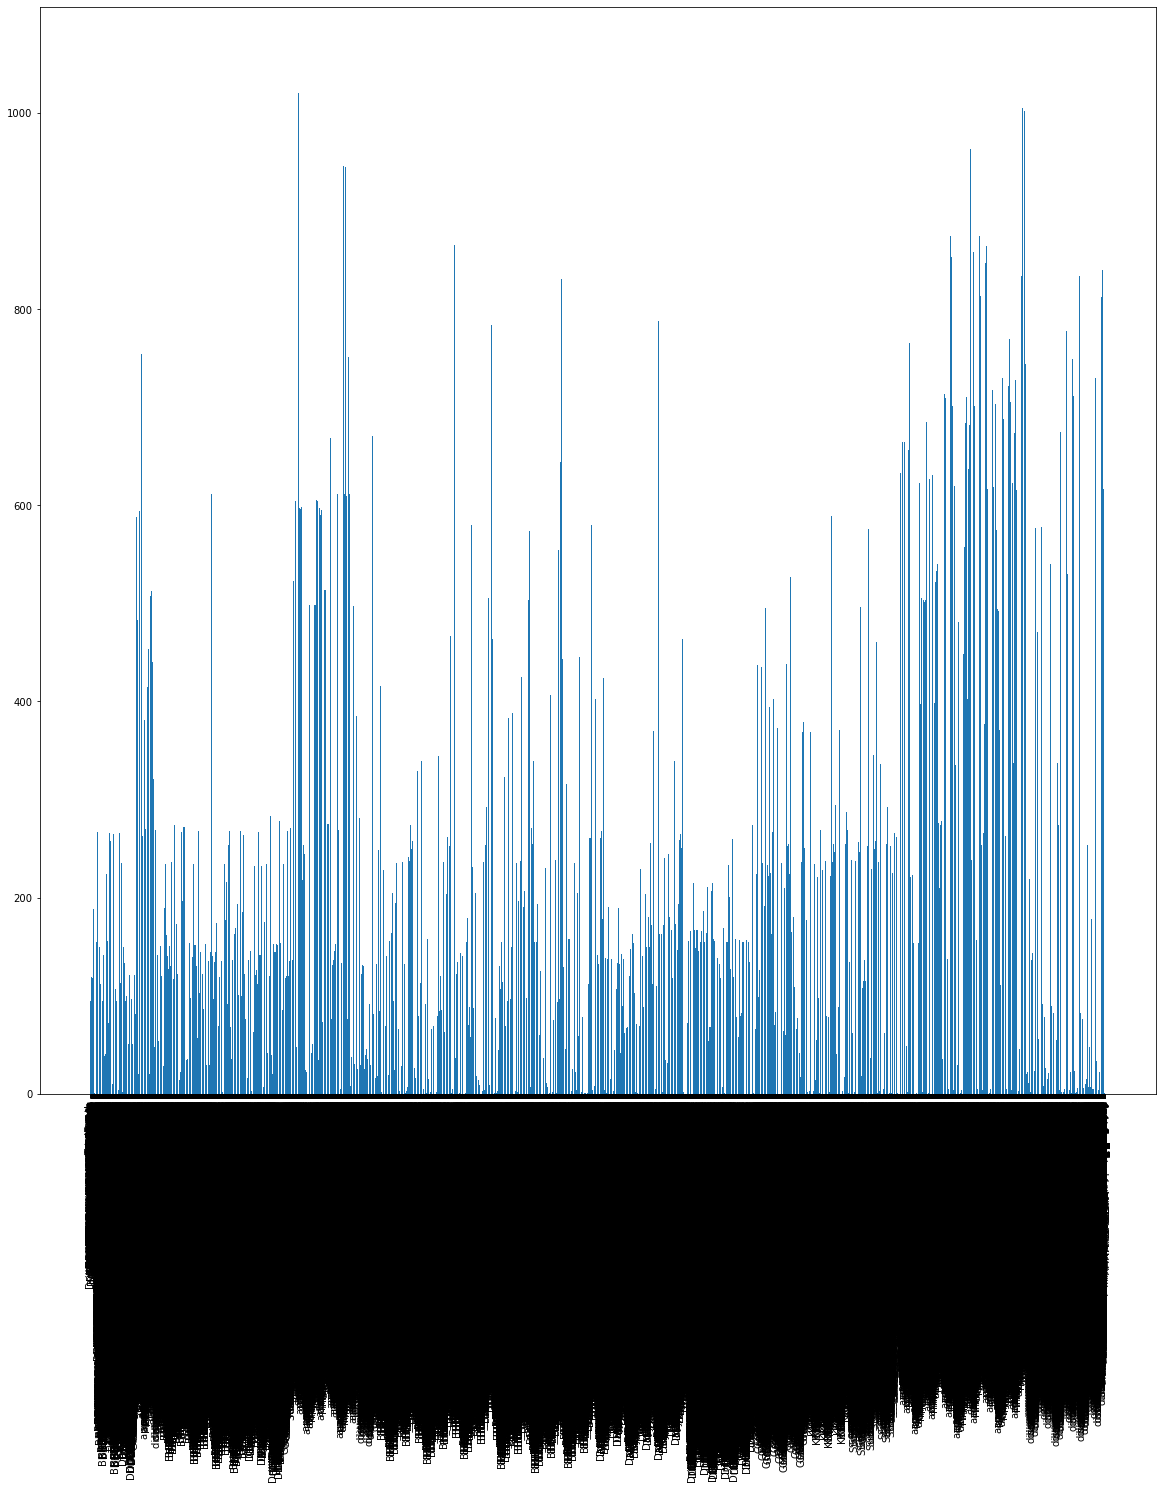

In [23]:
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (features.columns[i], fs.scores_[i]))
# plot the scores
plt.figure(figsize=(20,20))
plt.bar([features.columns[i] for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(rotation=90)
plt.show()


In [24]:
df = pd.DataFrame({'features':features.columns, 'score':fs.scores_})
df=df.sort_values(['score'],ascending=False)
dr.head(10)

,features,score
31094,approx - distance / DrillMetresPerDay + Ground...,1055.520838
31095,approx - distance / DrillMetresPerDay + KBElev...,1054.290777
31088,approx - distance / DaysDrilling - GroundEleva...,1031.068863
31089,approx - distance / DaysDrilling - KBElevation,1029.340542
8288,approx + DaysDrilling - distance + Surf_Longitude,1024.277069
...,...,...
8991,approx + distance - TotalDepth,NaN
26878,TotalDepth / approx + distance,NaN
27030,approx / distance - TotalDepth,NaN
29755,approx + distance / TotalDepth,NaN


## Data1: all data except for vertical wells, encoded 

In [10]:
#defining the dummy variables
wellheader2=wellheader[wellheader['WellProfile']!='Vertical']
data1=wellheader2[['WellProfile','Formation','WellTypeStandardised']]
data1_encode=pd.get_dummies(data1)
data1_encode['EPAssetsId']=wellheader2['EPAssetsId']
data1_encode['TotalDepth']=wellheader2['TotalDepth']
data1_encode['KBElevation']=wellheader2['KBElevation']
data1_encode['Surf_Longitude']=wellheader2['Surf_Longitude']
data1_encode['Surf_Latitude']=wellheader2['Surf_Latitude']
data1_encode['BH_Longitude']=wellheader2['BH_Longitude']
data1_encode['BH_Latitude']=wellheader2['BH_Latitude']
data1_encode['TVD']=wellheader2['TVD']
data1_encode.columns

cols=['EPAssetsId','WellProfile_Directional', 'WellProfile_Horizontal','Formation_Cardium', 'Formation_Duvernay', 'Formation_Montney',
       'Formation_Viking', 'WellTypeStandardised_Gas','WellTypeStandardised_Oil', 'TotalDepth', 'KBElevation',
       'Surf_Longitude', 'Surf_Latitude','BH_Longitude','BH_Latitude', 'TVD']
data1_encode=data1_encode[cols]
data1_encode
#data1_encode.to_csv("data1_encode.csv")

,EPAssetsId,WellProfile_Directional,WellProfile_Horizontal,Formation_Cardium,Formation_Duvernay,Formation_Montney,Formation_Viking,WellTypeStandardised_Gas,WellTypeStandardised_Oil,TotalDepth,KBElevation,Surf_Longitude,Surf_Latitude,BH_Longitude,BH_Latitude,TVD
0,2587301,0,1,0,0,1,0,0,1,3677.0,764.8,-117.529866,54.747632,-117.553826,54.743675,NaN
1,2593278,0,1,0,0,1,0,0,1,3607.0,770.8,-117.527042,54.737446,-117.553836,54.739474,1954.58
2,2579437,0,1,0,0,1,0,0,1,3502.0,759.4,-117.559923,54.730864,-117.534302,54.733247,1940.06
3,2591761,0,1,0,0,1,0,0,1,3491.0,759.8,-117.560141,54.730703,-117.534282,54.729643,1945.01
4,2587302,0,1,0,0,1,0,0,1,3578.0,767.7,-117.561283,54.723339,-117.534295,54.725986,1956.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10432,2619592,1,0,0,0,0,1,0,1,2076.0,777.7,-111.199446,51.895432,-111.188136,51.889342,889.74
10433,2621490,1,0,0,0,0,1,0,1,1976.0,798.9,-111.098455,51.959143,-111.107271,51.965748,NaN
10434,2614697,1,0,1,0,0,0,0,1,5531.0,1239.9,-114.367997,51.272852,-114.370708,51.242427,2254.61
10435,2613170,1,0,1,0,0,0,0,1,4779.0,1247.4,-114.336463,51.257185,-114.329028,51.234496,2209.00


In [11]:


#Generating a new column in data1_encode
data1_encode.reset_index(inplace=True,drop=True)

data1_encode['distance']=np.nan
for i in range(0,len(data1_encode)):
    lat1=data1_encode['Surf_Latitude'].values[i]
    lon1=data1_encode['Surf_Longitude'].values[i]
    lat2=data1_encode['BH_Latitude'].values[i]
    lon2=data1_encode['BH_Longitude'].values[i]
    data1_encode['distance'][i]=distance(lat1,lon1,lat2,lon2)
    
data1_encode['distance']=data1_encode['distance']*1000

data1_encode['approximate1']=data1_encode['TotalDepth']-data1_encode['distance']
data1_encode

C:\Users\mahta\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,EPAssetsId,WellProfile_Directional,WellProfile_Horizontal,Formation_Cardium,Formation_Duvernay,Formation_Montney,Formation_Viking,WellTypeStandardised_Gas,WellTypeStandardised_Oil,TotalDepth,KBElevation,Surf_Longitude,Surf_Latitude,BH_Longitude,BH_Latitude,TVD,distance,approximate1
0,2587301,0,1,0,0,1,0,0,1,3677.0,764.8,-117.529866,54.747632,-117.553826,54.743675,NaN,1600.022930,2076.977070
1,2593278,0,1,0,0,1,0,0,1,3607.0,770.8,-117.527042,54.737446,-117.553836,54.739474,1954.58,1735.275458,1871.724542
2,2579437,0,1,0,0,1,0,0,1,3502.0,759.4,-117.559923,54.730864,-117.534302,54.733247,1940.06,1666.700148,1835.299852
3,2591761,0,1,0,0,1,0,0,1,3491.0,759.8,-117.560141,54.730703,-117.534282,54.729643,1945.01,1665.030684,1825.969316
4,2587302,0,1,0,0,1,0,0,1,3578.0,767.7,-117.561283,54.723339,-117.534295,54.725986,1956.34,1758.423261,1819.576739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10426,2619592,1,0,0,0,0,1,0,1,2076.0,777.7,-111.199446,51.895432,-111.188136,51.889342,889.74,1030.342072,1045.657928
10427,2621490,1,0,0,0,0,1,0,1,1976.0,798.9,-111.098455,51.959143,-111.107271,51.965748,NaN,951.226979,1024.773021
10428,2614697,1,0,1,0,0,0,0,1,5531.0,1239.9,-114.367997,51.272852,-114.370708,51.242427,2254.61,3389.425192,2141.574808
10429,2613170,1,0,1,0,0,0,0,1,4779.0,1247.4,-114.336463,51.257185,-114.329028,51.234496,2209.00,2576.242244,2202.757756


In [12]:
data1_encode.columns

Index(['EPAssetsId', 'WellProfile_Directional', 'WellProfile_Horizontal',
       'Formation_Cardium', 'Formation_Duvernay', 'Formation_Montney',
       'Formation_Viking', 'WellTypeStandardised_Gas',
       'WellTypeStandardised_Oil', 'TotalDepth', 'KBElevation',
       'Surf_Longitude', 'Surf_Latitude', 'BH_Longitude', 'BH_Latitude', 'TVD',
       'distance', 'approximate1'],
      dtype='object')

## Standard Scaler

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data=data1_encode[['KBElevation','Surf_Longitude','Surf_Latitude','BH_Longitude','BH_Latitude','approximate1']].values
scaler.fit(data)
data_scaled=scaler.transform(data)

In [15]:
X_scaled=pd.DataFrame(data_scaled,columns=['KBElevation','Surf_Longitude','Surf_Latitude','BH_Longitude',
                                           'BH_Latitude','approximate1'])
X_scaled['EPAssetsId']=data1_encode['EPAssetsId']
X_scaled['WellProfile_Directional']=data1_encode['WellProfile_Directional']
#X_scaled['WellProfile_Horizontal']=data1_encode['WellProfile_Horizontal']
X_scaled['Formation_Cardium']=data1_encode['Formation_Cardium']
X_scaled['Formation_Duvernay']=data1_encode['Formation_Duvernay']
X_scaled['Formation_Montney']=data1_encode['Formation_Montney']
X_scaled['Formation_Viking']=data1_encode['Formation_Viking']
X_scaled['WellTypeStandardised_Gas']=data1_encode['WellTypeStandardised_Gas']
#X_scaled['WellTypeStandardised_Oil']=data1_encode['WellTypeStandardised_Oil']
X_scaled['bias']=1
X_scaled['TVD']=data1_encode['TVD']
X_scaled

,KBElevation,Surf_Longitude,Surf_Latitude,BH_Longitude,BH_Latitude,approximate1,EPAssetsId,WellProfile_Directional,Formation_Cardium,Formation_Duvernay,Formation_Montney,Formation_Viking,WellTypeStandardised_Gas,bias,TVD
0,-0.190917,-0.594714,0.592756,-1.225406,1.456030,0.762926,2587301,0,0,0,1,0,0,1,NaN
1,-0.144842,-0.594262,0.588853,-1.225408,1.453089,0.549418,2593278,0,0,0,1,0,0,1,1954.58
2,-0.232385,-0.599529,0.586330,-1.220636,1.448731,0.511529,2579437,0,0,0,1,0,0,1,1940.06
3,-0.229313,-0.599564,0.586269,-1.220631,1.446209,0.501823,2591761,0,0,0,1,0,0,1,1945.01
4,-0.168647,-0.599747,0.583447,-1.220634,1.443649,0.495173,2587302,0,0,0,1,0,0,1,1956.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10426,-0.091855,0.419375,-0.500246,0.329804,-0.541719,-0.309873,2619592,1,0,0,0,1,0,1,889.74
10427,0.070946,0.435553,-0.475831,0.349560,-0.488242,-0.331598,2621490,1,0,0,0,1,0,1,NaN
10428,3.457498,-0.088205,-0.738828,-0.447734,-0.994495,0.830122,2614697,1,1,0,0,0,0,1,2254.61
10429,3.515092,-0.083153,-0.744832,-0.437552,-1.000046,0.893766,2613170,1,1,0,0,0,0,1,2209.00


In [16]:
#remove the outliers from vikings
X_scaled=X_scaled[X_scaled['EPAssetsId']!=1170677]
X_scaled=X_scaled[X_scaled['EPAssetsId']!=1163751]
X_scaled[X_scaled['approximate1']<0]
X_scaled

,KBElevation,Surf_Longitude,Surf_Latitude,BH_Longitude,BH_Latitude,approximate1,EPAssetsId,WellProfile_Directional,Formation_Cardium,Formation_Duvernay,Formation_Montney,Formation_Viking,WellTypeStandardised_Gas,bias,TVD
0,-0.190917,-0.594714,0.592756,-1.225406,1.456030,0.762926,2587301,0,0,0,1,0,0,1,NaN
1,-0.144842,-0.594262,0.588853,-1.225408,1.453089,0.549418,2593278,0,0,0,1,0,0,1,1954.58
2,-0.232385,-0.599529,0.586330,-1.220636,1.448731,0.511529,2579437,0,0,0,1,0,0,1,1940.06
3,-0.229313,-0.599564,0.586269,-1.220631,1.446209,0.501823,2591761,0,0,0,1,0,0,1,1945.01
4,-0.168647,-0.599747,0.583447,-1.220634,1.443649,0.495173,2587302,0,0,0,1,0,0,1,1956.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10426,-0.091855,0.419375,-0.500246,0.329804,-0.541719,-0.309873,2619592,1,0,0,0,1,0,1,889.74
10427,0.070946,0.435553,-0.475831,0.349560,-0.488242,-0.331598,2621490,1,0,0,0,1,0,1,NaN
10428,3.457498,-0.088205,-0.738828,-0.447734,-0.994495,0.830122,2614697,1,1,0,0,0,0,1,2254.61
10429,3.515092,-0.083153,-0.744832,-0.437552,-1.000046,0.893766,2613170,1,1,0,0,0,0,1,2209.00


# Neural Network

In [17]:
data1_allTVD=X_scaled[X_scaled['TVD'].notna()]
#Data preparation

y2=data1_allTVD['TVD'].to_numpy()
X2=data1_allTVD.drop(['TVD'],axis=1)

# split data into train and test sets
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=test_size, random_state=101)
X_trainf=X_train.drop(['EPAssetsId'],axis=1)
X_testf=X_test.drop(['EPAssetsId'],axis=1)

In [18]:
X_scaled=X_scaled[['EPAssetsId', 'KBElevation', 'Surf_Longitude', 'Surf_Latitude', 'BH_Longitude',
       'BH_Latitude', 'approximate1', 'WellProfile_Directional','Formation_Cardium', 'Formation_Duvernay',
        'Formation_Montney','Formation_Viking', 'WellTypeStandardised_Gas', 'bias']]


Submission=pd.read_csv('Submission_Sample.csv')
Submission.drop(['TVD'],axis=1,inplace=True)

Submission_TVDs=pd.merge(Submission, X_scaled, how='left',left_on='EPAssetsId', right_on='EPAssetsId',left_index=False,
                right_index=False)


#Predict TVDs
X3pred=Submission_TVDs.drop(['EPAssetsId'],axis=1)


In [ ]:
## all the parameter cases
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100, 250, 500, 1000, 1500]
neurons = [1, 5, 10, 15, 20, 25, 30]
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

In [ ]:
#going through the paramteres and saving the results
tic = time.clock()
z=0
counter=0
predictions=pd.DataFrame(data=np.ones((400,4)),columns=['Neurons' ,'Optimizer','Epochs','Test_RMSE'])    
neurons = [48,53,60,68,80,96,120,160,240,480,600]
optimizer = ['RMSprop', 'Adam', 'Adamax', 'Nadam']
epochs=[300,600,900,1200,1500,2000]
a=['onee','two','three','four','five','six','seven','eight','nine','ten','ten1','ten2','ten3','ten4','ten5','ten6',
  'ten7','ten8','ten9','ten10','ten11','ten12','ten13','ten14','ten15','ten16','ten17','ten18','ten19','ten20','ten21','ten22',
  'ten23','ten24','ten25','ten26','ten27','ten28','ten29','ten30','ten31','ten32','ten33','ten34','ten35','ten36','ten37','ten38',]
for i in neurons:
    for j in optimizer:
        for k in epochs:
            my_init = initializers.normal(seed=101)
            model = Sequential()
            model.add(Dense(i, input_dim=13,kernel_initializer=my_init, activation='relu'))
            model.add(Dense(i,kernel_initializer=my_init, activation='relu'))
            model.add(Dense(i,kernel_initializer=my_init, activation='relu'))
            model.add(Dense(1, kernel_initializer=my_init,activation='relu'))
            # Compile model
            model.compile(loss='mse', optimizer=j, metrics=['mse'])
            # fit the model
            model.fit(X1, y1, epochs=k, batch_size=128, verbose=0)

            preds = model.predict(X_testf)
            mse = mean_squared_error(y_test, preds)
            test_rmse=math.sqrt(mse)
            print('With Neurons= %s and Optimizer = %s and epochs = %s: '% (i,j,k))
            print('Test_RMSE:', test_rmse)
            
            if test_rmse < 20:
                # store prediction
                
                predictions['Neurons'][counter]=i
                predictions['Optimizer'][counter]=j
                predictions['Epochs'][counter]=k
                predictions['Test_RMSE'][counter]=test_rmse
                counter=+1
                exec('{} = pd.DataFrame()'.format(a[z]))
                Submission_TVDs['TVDpred']=model.predict(X3pred)
                exec('{}=Submission_TVDs'.format(a[z]))
                z=z+1
                print(z)
        
toc = time.clock()
toc - tic


In [ ]:
# Based on the obtained results, a number of "while" loops were defined to get the least error for each combination, 
#here is an example of one of the combinations (initializer=normal, activation=relu, optimizer=Adamax, batch size=128, epoches=2000, neurons=240)

In [ ]:
# define model
rmse=100
while rmse > 24:
    neurons=240
    my_init = initializers.normal(seed=101)
    model = Sequential()
    model.add(Dense(neurons, input_dim=13,kernel_initializer=my_init, activation='relu'))
    model.add(Dense(neurons,kernel_initializer=my_init, activation='relu'))
    model.add(Dense(neurons,kernel_initializer=my_init, activation='relu'))
    model.add(Dense(1, kernel_initializer=my_init,activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer='Adamax', metrics=['mse'])

    # fit the model
    model.fit(X1, y1, epochs=2000, batch_size=128, verbose=0)

    preds = model.predict(X_testf)
    mse = mean_squared_error(y_test, preds)
    rmse=math.sqrt(mse)
    print('Test_RMSE:', rmse)

In [ ]:
# the final uploaded result was based on the average of the 20 runs meeting the above criteria.